In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train_labels.csv', 'sample_submission.csv']


In [2]:
from glob import glob 
from skimage.io import imread #read images from files
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical   

Using TensorFlow backend.


In [3]:
train_y = pd.read_csv('../input/train_labels.csv')

In [4]:
base_tile_dir = '../input/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
labels = pd.read_csv("../input/train_labels.csv")
df = df.merge(labels, on = "id")
df.head(5)

,path,id,label
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b,0
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753,0
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98,0
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4,0
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d,0


In [5]:
#df['image'] = df['path'].map(imread)
df.shape

(220025, 3)

In [6]:
#imgplot = plt.imshow(df['image'][0])

In [7]:
#df_train, df_test = train_test_split(df, test_size=0.3)
df_train=df

In [8]:
#df_train.shape, df_test.shape

In [9]:
df_train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [10]:
#df_test['label'].value_counts()

In [11]:
train_y=df_train['label']
train_y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [12]:
train_x=df_train['path']
train_x.head(5)

0    ../input/train/292faf631c5ff5741bb46b04e4eacce...
1    ../input/train/5a61b93a34e2a37869a4e83e964169a...
2    ../input/train/139e7bd057aafacf7cce59490104ccf...
3    ../input/train/5adf6b5ce28b15f585b8d53fc8d3716...
4    ../input/train/abf7a7eb3e7bc917e766670eebd7f44...
Name: path, dtype: object

In [13]:
base_tile_dir = '../input/test/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
df_test=df

In [14]:
#test_y=df_test['label']
#test_y.head(5)

In [15]:
test_x=df_test['path']
test_x.head(5)

0    ../input/test/0eb051700fb6b1bf96188f36c8e48895...
1    ../input/test/c99d6bc4cee9df4c93a0c3f4138664db...
2    ../input/test/2859428095a9d1e6aba4bc135c69b596...
3    ../input/test/13141967dff006e2e3f65282a02d3faf...
4    ../input/test/ad15cf4e12c953fd5822eec528c55a54...
Name: path, dtype: object

In [16]:
training_iters = 40
learning_rate = 0.001 
batch_size = 256
#data input (img shape: 96*96)
n_input = 96
#total classes
n_classes = 2

In [17]:
#both placeholders are of type float
x = tf.placeholder("float", [None, 96,96,3])
y = tf.placeholder("float",[None,2])

In [18]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.layers.batch_normalization(x,training=True)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [19]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,3,16), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,16,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc4': tf.get_variable('W3', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
    'wc5': tf.get_variable('W4', shape=(3,3,128,256), initializer=tf.contrib.layers.xavier_initializer()),
    'wc6': tf.get_variable('W5', shape=(3,3,256,512), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W6', shape=(12*12*512,512), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W7', shape=(512,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc4': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bc5': tf.get_variable('B4', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'bc6': tf.get_variable('B5', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B6', shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B7', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 48*48 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 24*24.
    conv4 = maxpool2d(conv4, k=2)
    
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 12*12.
    conv6 = maxpool2d(conv6, k=2)

    # Fully connected layer
    # Reshape conv6 output to fit fully connected layer input
    fc1 = tf.reshape(conv6, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=0.25)  # DROP-OUT here
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [21]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [22]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
prediction = tf.argmax(pred, 1)

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
# Initializing the variables
init = tf.global_variables_initializer()

In [24]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    #test_loss = []
    train_accuracy = []
    #test_accuracy = []
    #test_acc = [0.0] * (len(test_x)//batch_size)
    #valid_loss = [0.0] * (len(test_x)//batch_size)
    test_pred= np.array([])#[0] * len(test_x)
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_x)//batch_size):
            batch_x = train_x[batch*batch_size:min((batch+1)*batch_size,len(train_x))].map(imread)
            batch_x=batch_x.values
            batch_x=np.asarray([a.reshape(96,96,3) for a in batch_x])
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]  
            batch_y=batch_y.values
            batch_y=to_categorical(batch_y, num_classes=2)
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")
        train_loss.append(loss)
        #test_loss.append(np.average(valid_loss))
        train_accuracy.append(acc)
        #test_accuracy.append(np.average(test_acc))

    # Calculate accuracy for all test images
    for batch in range(len(test_x)//batch_size+1):
        test_batch_x = test_x[batch*batch_size:min((batch+1)*batch_size,len(test_x))].map(imread)
        test_batch_x=test_batch_x.values
        test_batch_x=np.asarray([a.reshape(96,96,3) for a in test_batch_x])
        #test_batch_y = test_y[batch*batch_size:min((batch+1)*batch_size,len(test_y))]
        #test_batch_y=test_batch_y.values
        #test_batch_y=to_categorical(test_batch_y, num_classes=2)
        #test_acc[batch],valid_loss[batch],test_pred[batch*batch_size:min((batch+1)*batch_size,len(test_y))] = sess.run([accuracy,cost,prediction], feed_dict={x: test_batch_x,y : test_batch_y})
        y_list=sess.run([prediction], feed_dict={x: test_batch_x})
        y_array=y_list[0]
        test_pred=np.concatenate((test_pred,y_array))
    summary_writer.close()

Iter 0, Loss= 0.496065, Training Accuracy= 0.78906
Optimization Finished!
Iter 1, Loss= 0.358788, Training Accuracy= 0.84766
Optimization Finished!
Iter 2, Loss= 0.308640, Training Accuracy= 0.85938
Optimization Finished!
Iter 3, Loss= 0.314527, Training Accuracy= 0.91406
Optimization Finished!
Iter 4, Loss= 0.363124, Training Accuracy= 0.87109
Optimization Finished!
Iter 5, Loss= 0.288836, Training Accuracy= 0.89062
Optimization Finished!
Iter 6, Loss= 0.282054, Training Accuracy= 0.91797
Optimization Finished!
Iter 7, Loss= 0.280789, Training Accuracy= 0.90625
Optimization Finished!
Iter 8, Loss= 0.198147, Training Accuracy= 0.92969
Optimization Finished!
Iter 9, Loss= 0.162790, Training Accuracy= 0.93359
Optimization Finished!
Iter 10, Loss= 0.151426, Training Accuracy= 0.94922
Optimization Finished!
Iter 11, Loss= 0.109764, Training Accuracy= 0.96875
Optimization Finished!
Iter 12, Loss= 0.145469, Training Accuracy= 0.95312
Optimization Finished!
Iter 13, Loss= 0.100309, Training A

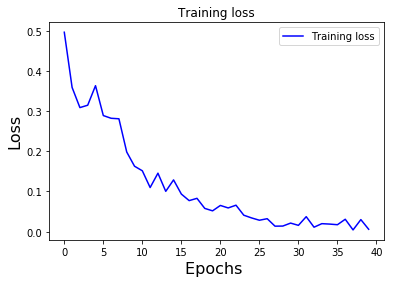

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
#plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
#plt.title('Training and Test loss')
plt.title('Training loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

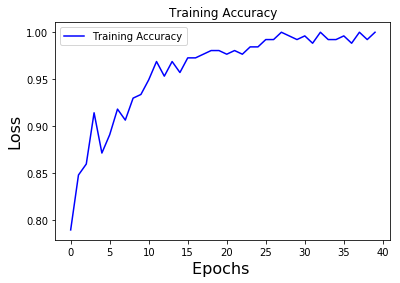

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
#plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
#plt.title('Training and Test Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [27]:
#import sklearn.metrics as metrics
#fpr, tpr, _ = metrics.roc_curve(test_pred, test_y.values)
#auc = metrics.roc_auc_score(test_pred, test_y.values)
#plt.plot(fpr,tpr,label="6 Layer with dropout, auc="+str(auc))
#plt.legend(loc=4)
#plt.show()
#fpr,tpr
subm=df_test
subm['label']=test_pred.astype('int32')
subm=subm.drop(columns='path')
subm.index=subm.index+1
subm.to_csv('sub.csv')
#subm
#df_test['label']=test_pred
#df_test.head(5)